### Import libraries

In [1]:
from pyspark import SparkContext
import numpy as np

### Initialize a SparkContext (the main abstraction to the cluster)
Note the '4' in the argument. It denotes 4 cores to be used for this SparkContext object.

In [2]:
sc=SparkContext(master="local[4]")

In [3]:
print(sc)

<SparkContext master=local[4] appName=pyspark-shell>


### Generate a list of random integers

In [4]:
lst = np.random.randint(0,10,20)

In [5]:
print(lst)

[2 1 0 5 4 9 6 9 7 6 3 6 2 2 0 6 2 8 2 2]


### Parallelize the list - this is the main operation toward distributed computing

In [6]:
A=sc.parallelize(lst)

### What did we just do? We created a RDD? What is a RDD?

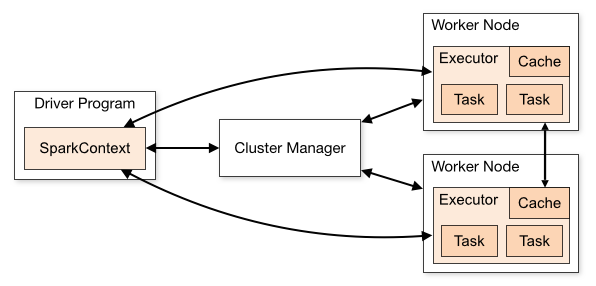

Spark revolves around the concept of a resilient distributed dataset (RDD), which is a fault-tolerant collection of elements that can be operated on in parallel. SparkContext manages the distributed data over the worker nodes through the cluster manager.

There are two ways to create RDDs:

1. parallelizing an existing collection in your driver program, or
2. referencing a dataset in an external storage system, such as shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat.

We created a RDD using the former approach

### A is a pyspark RDD object, we cannot access the elements directly

In [7]:
type(A)

pyspark.rdd.RDD

In [8]:
A

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:262

### Opposite to parallelization - collect brings all the distributed elements and returns them to the head node.

Note- this is a slow process, do not use it often.

In [9]:
A.collect()

[2, 1, 0, 5, 4, 9, 6, 9, 7, 6, 3, 6, 2, 2, 0, 6, 2, 8, 2, 2]

In [10]:
A.glom().collect()

[[2, 1, 0, 5, 4], [9, 6, 9, 7, 6], [3, 6, 2, 2, 0], [6, 2, 8, 2, 2]]

### Now stop the SC and reinitialize it with 2 cores and see what happens when you repeat the process!

In [11]:
sc.stop()

In [12]:
sc=SparkContext(master="local[2]")

In [13]:
A = sc.parallelize(lst)

In [14]:
A.glom().collect()

[[2, 1, 0, 5, 4, 9, 6, 9, 7, 6], [3, 6, 2, 2, 0, 6, 2, 8, 2, 2]]

### The RDD is now distributed over two chunks, not four!

So, let's redo the process with 4 cores again.

In [15]:
sc.stop()

In [16]:
sc = SparkContext(master="local[4]")

In [17]:
A = sc.parallelize(lst)

## Basic operations

### Count the elements

In [18]:
A.count()

20

### The first element (first) and the first few elements (take)

In [19]:
A.first()

2

In [20]:
A.take(4)

[2, 1, 0, 5]

### Removing duplicates: Get another RDD with only the distinct elements

The method RDD.distinct() Returns a new dataset that contains the distinct elements of the source dataset.

NOTE: This operation requires a shuffle in order to detect duplication across partitions. So, it is a slow operation.

In [21]:
A_distinct=A.distinct()

In [22]:
A_distinct.collect()

[0, 4, 8, 1, 5, 9, 2, 6, 7, 3]

### To sum all the elements use reduce method

In [23]:
A.reduce(lambda x,y:x+y)

82

### Or direct sum method

In [24]:
A.sum()

82

### Or using the fold method, which aggregates the elements of each partition, and then the results for all the partitions

In [25]:
A.fold(0,lambda x,y:x+y)

82

### Finding maximum element by reduce

In [26]:
A.reduce(lambda x,y: x if x > y else y)

9

### Finding longest word using reduce

In [27]:
words = 'These are some of the best Macintosh computers ever'.split(' ')
wordRDD = sc.parallelize(words)
wordRDD.reduce(lambda w,v: w if len(w)>len(v) else v)

'computers'

## Functions/filtering over RDD

#### Use filter to return a new RDD with elements satisfying a given predicate (lambda expression)

In [28]:
# Return RDD with elements divisible by 3
A.filter(lambda x:x%3==0).collect()

[0, 9, 6, 9, 6, 3, 6, 0, 6]

#### Lambda functions are short and sweet but we can write regular Python functions to use with reduce

In [29]:
def largerThan(x,y):
    """
    Returns the last word among the longest words in a list
    """
    if len(x)> len(y):
        return x
    elif len(y) > len(x):
        return y
    else:
        if x < y: return x
        else: return y

In [30]:
wordRDD.reduce(largerThan)

'Macintosh'

### Sampling an RDD
1. RDDs are often very large.
2. Aggregates, such as averages, can be approximated efficiently by using a sample. This comes handy often for operation with extremely large datasets where a sample can tell a lot about the pattern and descriptive statistics of the data.
3. Sampling is done in parallel and requires limited computation.

The method RDD.sample(withReplacement,p) generates a sample of the elements of the RDD. where 

1. withReplacement is a boolean flag indicating whether or not a an element in the RDD can be sampled more than once.
2. p is the probability of accepting each element into the sample. Note that as the sampling is performed independently in each partition, the number of elements in the sample changes from sample to sample.

In [31]:
# get a sample whose expected size is m
# Note that the size of the sample is different in different runs
m=5
n=20
print('sample1=',A.sample(False,m/n).collect()) 
print('sample2=',A.sample(False,m/n).collect())

sample1= [5, 9, 3]
sample2= [2, 1, 5, 9, 0]


### Things to note and think about
1. Each time you run the previous cell, you get a different estimate
2. The accuracy of the estimate is determined by the size of the sample $n*p$. Here, probability $p=\frac{m}{n}$
3. See how the error changes as you vary $p$

## Basic statistics

In [32]:
print("Maximum: ",A.max())
print("Minimum: ",A.min())
print("Mean (average): ",A.mean())
print("Standard deviation: ",A.stdev())

Maximum:  9
Minimum:  0
Mean (average):  4.1
Standard deviation:  2.808914381037628


In [33]:
A.stats()

(count: 20, mean: 4.1, stdev: 2.808914381037628, max: 9.0, min: 0.0)

## Mapping

#### map operation with lambda function

In [34]:
B=A.map(lambda x:x*x)

In [35]:
B.collect()

[4, 1, 0, 25, 16, 81, 36, 81, 49, 36, 9, 36, 4, 4, 0, 36, 4, 64, 4, 4]

#### map operation with regular Python function

In [36]:
def square_if_odd(x):
    if x%2==1:
        return x*x
    else:
        return x

In [37]:
A.map(square_if_odd).collect()

[2, 1, 0, 25, 4, 81, 6, 81, 49, 6, 9, 6, 2, 2, 0, 6, 2, 8, 2, 2]

#### flatmap method returns a new RDD by first applying a function to all elements of this RDD, and then flattening the results

In [38]:
A.flatMap(lambda x:(x,x*x)).collect()

[2,
 4,
 1,
 1,
 0,
 0,
 5,
 25,
 4,
 16,
 9,
 81,
 6,
 36,
 9,
 81,
 7,
 49,
 6,
 36,
 3,
 9,
 6,
 36,
 2,
 4,
 2,
 4,
 0,
 0,
 6,
 36,
 2,
 4,
 8,
 64,
 2,
 4,
 2,
 4]

## Grouping and binning

#### groupby returns a RDD of grouped elements (iterable) as per a given group operation (function)

In [39]:
result=A.groupBy(lambda x:x%2).collect()
sorted([(x, sorted(y)) for (x, y) in result])

[(0, [0, 0, 2, 2, 2, 2, 2, 2, 4, 6, 6, 6, 6, 8]), (1, [1, 3, 5, 7, 9, 9])]

#### histogram method takes a list of bins/buckets and returns a tuple with result of the histogram (binning)

In [40]:
B.histogram([x for x in range(0,100,10)])

([0, 10, 20, 30, 40, 50, 60, 70, 80, 90], [10, 1, 1, 4, 1, 0, 1, 0, 2])

## Set operations

### Create smaller RDDs to demonstrate joint operations

In [41]:
lst1=np.random.randint(0,10,3)
C=sc.parallelize(lst1)
lst2=np.random.randint(10,20,3)
D=sc.parallelize(lst2)
print("C:",C.collect())
print("D:",D.collect())

C: [9, 1, 1]
D: [19, 18, 14]


### C+D gives the union (like set union), not the element wise sum

In [42]:
(C+D).collect()

[9, 1, 1, 19, 18, 14]

### cartesian gives the pairwise product (as tuples)

In [43]:
C.cartesian(D).collect()

[(9, 19),
 (9, 18),
 (9, 14),
 (1, 19),
 (1, 18),
 (1, 14),
 (1, 19),
 (1, 18),
 (1, 14)]

#### intersection and subtractmethods return a RDD of the set intersection and subtraction (difference)

In [44]:
rdd1 = sc.parallelize([1, 10, 2, 3, 4, 5])
rdd2 = sc.parallelize([1, 6, 2, 3, 7, 8])
rdd1.intersection(rdd2).collect()

[1, 2, 3]

In [45]:
rdd1.subtract(rdd2).collect()

[10, 4, 5]

### Stop the SparkContext at the end

In [46]:
sc.stop()